# A Supernova Lightcurve

ReacLib provides the beta-decay constants for radioactive nuclei, and these can be treated like any other rate.  So we can build a network with ${}^{56}\mathrm{Ni}$ and compute its decay.

In [1]:
import pynucastro as pyna

import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

We'll look at ${}^{56}\mathrm{Ni} \rightarrow {}^{56}\mathrm{Co} \rightarrow {}^{56}\mathrm{Fe}$

In [2]:
nuclei = ["ni56", "co56", "fe56"]

In [3]:
rl = pyna.ReacLibLibrary()
lib = rl.linking_nuclei(nuclei)

We see that we pull in 2 rates, which are simple decays.

In [4]:
lib

Co56 ⟶ Fe56 + e⁺ + 𝜈           [Q =   4.57 MeV] (Co56 --> Fe56 <wc12_reaclib_weak_>)
Ni56 ⟶ Co56 + e⁺ + 𝜈           [Q =   2.13 MeV] (Ni56 --> Co56 <wc12_reaclib_weak_>)

In [5]:
net = pyna.PythonNetwork(libraries=[lib])

We can write out the network to solve.

In [6]:
net.write_network("decay.py")

In [7]:
#%pycat decay.py

In [8]:
import decay

We'll start out with pure ${}^{56}\mathrm{Ni}$ and convert to molar fractions, since that's what we integrate.

In [9]:
X = np.zeros(len(net.unique_nuclei))
X[decay.jni56] = 1.0
Y0 = X / decay.A

Even though the rates have no density or temperature dependence, we still need to pass in a $(\rho, T)$, so we'll just set them to arbitrary values.

In [10]:
rho0 = 1.0
T0 = 1.0

We'll integrate for 400 days

In [11]:
seconds_per_day = 24 * 3600
tmax = 400 * seconds_per_day

We can use the default integrator in `solve_ivp()` since this system is not stiff.

In [12]:
sol = solve_ivp(decay.rhs, [0, tmax], Y0,
                dense_output=True, args=(rho0, T0), rtol=1.e-8, atol=1.e-10)

Now we can look at the evolution of the composition

Text(0, 0.5, 'X')

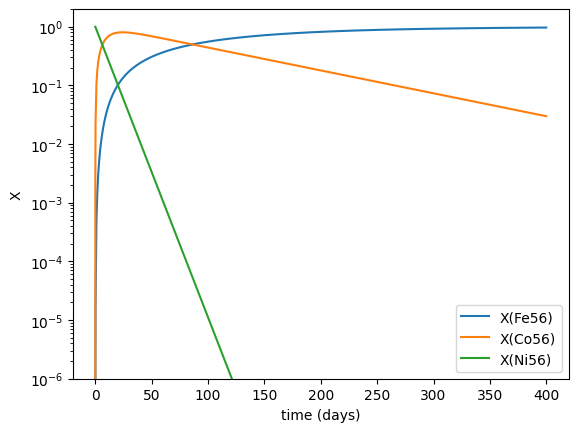

In [13]:
fig, ax = plt.subplots()
for n in range(len(net.unique_nuclei)):
    ax.semilogy(sol.t / seconds_per_day, decay.A[n] * sol.y[n, :], label=f"X({decay.names[n].capitalize()})")
ax.set_ylim(1.e-6, 2)
ax.legend()
ax.set_xlabel("time (days)")
ax.set_ylabel("X")

If we want the luminosity, we can compute that as the instantaneous energy release.  Note: this assumes that all of the energy release is given to photons.  For this, we need the rates, which we can get these by iterating over the solution

In [14]:
L = []
for n in range(sol.y.shape[-1]):
    Y = sol.y[:, n]
    dYdt = decay.rhs(sol.t[n], Y, rho0, T0)
    L.append(decay.energy_release(dYdt))

L is now in erg/g/s, so we should multiply by the initial ${}^{56}\mathrm{Ni}$ mass.

In [15]:
M_sun = 2.e33
L_sun = 4.e33

# initial mass
M_Ni56 = 1.0 * M_sun

In [16]:
L = np.array(L) * M_sun

Now we can plot the lightcurve.

Text(0, 0.5, 'luminosity (solar)')

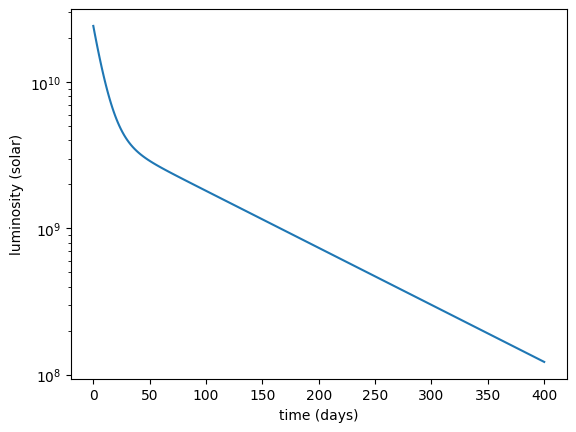

In [17]:
fig, ax = plt.subplots()
ax.semilogy(sol.t / seconds_per_day, L / L_sun)
ax.set_xlabel("time (days)")
ax.set_ylabel("luminosity (solar)")